In [2]:
# !pip install ipynb
# from ipynb.fs.full.useful_functions import *

from ipynb.fs.full.functions_for_QAOAAnsatz import *

### Random parameters minimization


##### Da k trovo h = k+epsilon

In [14]:
# k_vector = [0.0625, 0.125, 0.075, 0.125, 0.041666666666666664, 0.09375, 0.0625, 0.125, 0.16666666666666666, 0.09375]

# import math
# def round_up(n, decimals=0):
#     multiplier = 10**decimals
#     return math.ceil(n * multiplier) / multiplier        
        
# h_vector = [t+0.001 if round_up(t,3)==t else round_up(t,3) for t in k_vector]
# print(h_vector)

[0.167, 0.167, 0.251, 0.167, 0.333, 0.251, 0.251, 0.167, 0.083, 0.083]


In [15]:

# prendo la media tra il rosso e 1 
h_vector = [0.167, 0.167, 0.251, 0.167, 0.333, 0.251, 0.251, 0.167, 0.083, 0.083] 

h_vector = [(h+1)/2 for h in h_vector]
print(h_vector)

[0.5835, 0.5835, 0.6255, 0.5835, 0.6665, 0.6255, 0.6255, 0.5835, 0.5415, 0.5415]


##### scelgo i parametri e faccio la minimizzazione pe rogni istanza da 1 a 10

In [ ]:
n = 6
init_name = "all1"
p = 3
random_attempts = 10

for instance in range(1,11):
    h = h_vector[instance-1]
    
    FILENAME_list = []
    DATA_FILENAME_list = []
    
    U, subsets_dict = define_instance(n, instance, verbose=False)
    
    subsets = list(subsets_dict.values())
    _,_, _, _, EXACT_COVERS = find_spectrum(U, subsets_dict, n, h)
    MEC = [state for state in EXACT_COVERS if state.count("1") == min([x.count("1")  for x in EXACT_COVERS])]
    
    # show_spectrum(n, instance, h)
    A, B, hamiltonian, qc_cost = build_cost_circuit(n, instance, h, verbose=False)
    qc_mixing = build_mixing_circuit(n, instance, verbose=False)
    qc_initial = build_initialization_circuit(n, instance, init_name, verbose=False)
    
    ###########################################################
    ###########################################################
    gamma_bound = find_gamma_bound(n, instance, h, verbose=False)
    
    beta_0 = (0, 2*np.pi)
    gamma_0 =  (-gamma_bound, gamma_bound)
    string_0 = f"[0,2pi]x[-{gamma_bound},{gamma_bound}]"
    
    bnds_beta = (0, 2*np.pi)
    bnds_gamma = (-gamma_bound, gamma_bound)
    bnds_string = f"[0,2pi]x[-{gamma_bound},{gamma_bound}]"
    
    ###########################################################
    ###########################################################
    
    ### BUILD FILE NAMES
    # current_datetime = datetime.now().strftime("@%Y-%m-%d@%Hh%Mm%Ss")
    current_datetime = datetime.now().strftime("%d-%m")
    
    # This file will contain the final histograms.
    header = f"kMECmean1_{current_datetime}_dim{n}_mail{instance}_{init_name}_random_p{p}_{random_attempts}ra_k{h}_BOUNDS{bnds_string}_pars0{string_0}"
    print(header)
    
    # This file will contain important data such as energies, betas, gammas.
    from ast import literal_eval
    DATA_FILENAME = header + '_data.txt'
    FILENAME = header + ".csv"

    FILENAME_list.append(FILENAME)
    DATA_FILENAME_list.append(DATA_FILENAME)
    
    
    ###########################################################
    ###########################################################
    ### DO THE MINIMIZATION
    with open(DATA_FILENAME, 'a') as DATA_FILE:
        # DATA_FILE.write(f"The initial state is an equal superposition of: {init_state} \n")
        DATA_FILE.write(f"current datetime = {datetime.now().strftime('@%Y-%m-%d@%Hh%Mm%Ss')}")
        DATA_FILE.write(f"p={p}\n")
    
        E_best = 100
        counter = 0
        TOTAL_start_time = time.time()
    
    
        for i in range(1,random_attempts+1):
            print(f"----- {i}/{random_attempts} random_attempts -----", end="\r")
            
            DATA_FILE.write(f"\n----- {i}/{random_attempts} random_attempts -----\n")
            ansatz = QAOAAnsatz(qc_cost, mixer_operator=qc_mixing, initial_state=qc_initial, reps=p, name='my_QAOA_circuit')
    
    
            # Generate a pass manager without providing a backend
            pm = generate_preset_pass_manager(optimization_level=3)
            ansatz_isa = pm.run(ansatz)
            hamiltonian_isa = hamiltonian.apply_layout(ansatz_isa.layout)
        
            estimator = StatevectorEstimator()
            sampler = StatevectorSampler()
        
            
            # *******************************  MINIMIZE  **********************************
            # # Do the minimization.
            pars_0 = [random.uniform(*beta_0) for _ in range(p)] + [random.uniform(*gamma_0) for _ in range(p)]
            
            # print('Initial parameters (for the minimization): pars_0 = ', pars_0)
    
            
            bnds = [bnds_beta]*p + [bnds_gamma]*p
            res = minimize(cost_func, pars_0, bounds=bnds,
                           args=(ansatz_isa, hamiltonian_isa, estimator), 
                           method="Nelder-Mead", options={"maxiter": 1000}, tol=1e-4)
            
            # Select the optimal parameters [beta,gamma] found.
            betas = list(res.x[:p])
            gammas = list(res.x[p:])
            # print(f"Final parameters (after minimization): betas, gammas = {betas}, {gammas}")
        
            E_min = res.fun -A -B    
            # print(f"E_min = res.fun - A - B = {E_min}")
            DATA_FILE.write(f"\nE_min = {E_min}")
            # print(f'E_min\'s parameters: betas, gammas = ', betas, gammas)
            DATA_FILE.write(f'\nE_min\'s parameters: betas = {betas}, gammas = {gammas}\n')
    
            if E_min < E_best:
                    E_best = E_min
                    i_best = i 
                    # print("***UPDATING***")
        
                    
            # ****************************  RUN THE CIRCUIT  ******************************
            # Assign to the ansatz the 2p parameters found, then run the circuit.
            pars = betas + gammas
            qc = ansatz.assign_parameters(pars)
            qc.measure_all()
            qc_isa = pm.run(qc)
            result = sampler.run([qc_isa], shots=1024).result()
            samp_dist = result[0].data.meas.get_counts()
    
            ##########################################################à
        
            
            # ****************************  POST PROCESS  **********************************
            # Create a dataframe out of the sampling's results.
            df = pd.DataFrame(samp_dist.items()).rename(columns={0: 'states', 1: 'counts'})
            _, _, NUM_ANC, _ = get_circuit_parameters(subsets, verbose=False)
            df['states'] = df['states'].apply(lambda x: x[NUM_ANC:]) # remove ancillary bits
            df = df.groupby(['states']).sum()
            
            # Create a dictionary with states and occurrences.
            d = df['counts'].to_dict()
            lists = sorted(d.items(), key=lambda item: item[1], reverse=True)
        
            # Invert bit order ("01101 -> 10110")      
            d = invert_counts(d)
        
        
            # **************************** PLOT THE i-TH DATAFRAME ****************************
            # plt.figure(figsize=(15,5))
            # plt.rcParams['font.size'] = 13
            # plt.title(f"Ansatz with p={p}, {i} of {random_attempts}")
            # plt.ylim(0,1024)
            # plt.grid()
            df = pd.DataFrame(d.items())
            df = df.rename(columns={0: 'states', 1: f'counts_p{p}_{i}of{random_attempts}'})    
            df = df.sort_values(f'counts_p{p}_{i}of{random_attempts}', ascending=False) 
            
            # ax = sns.barplot(x='states', y=f'counts_p{p}_{i}of{random_attempts}', data=df)
            
            # # Make labels with percentages.
            # labels = df[f'counts_p{p}_{i}of{random_attempts}'].apply(lambda x: (x/df[f'counts_p{p}_{i}of{random_attempts}'].sum())*100).round(1).astype('str') + '%'
            # for container in ax.containers:
            #     ax.bar_label(container, labels=labels, fontsize=11)
                
            # # Highlight with red the exact covers
            # highlight_correct_ticks(ax, list(df["states"]), EXACT_COVERS)
            # plt.show()
    
            # Merge dataframes.
            if i == 1:
                df_final = df
            else:
                df_final = pd.merge(df_final, df, on="states", how="outer")    
    
            if df['states'].iloc[0] == MEC:    
                DATA_FILE.write("\n### Most frequent state is MEC ###\n")
                counter += 1
        
        # ################### SAVE TO CSV AND FIX BETA,GAMMA ###################
        # Save to csv.
        df_final.to_csv(FILENAME, index=False)
    
        ######################################################################
        DATA_FILE.write("\n*******************************")
        DATA_FILE.write(f"\nAttempt that reached the best result with E_min = {E_best} is #{i_best} ")
        DATA_FILE.write(f"\nMost frequent state was MEC / random attempts = {counter} / {random_attempts} = {round((counter/random_attempts)*100, 1)}%\n")
        
    
        print(f"\nTOTAL ELAPSED TIME: {(time.time() - TOTAL_start_time)/60} minutes.")
        DATA_FILE.write(f"\nTOTAL ELAPSED TIME: {(time.time() - TOTAL_start_time)/60} minutes.\n")

kMECmean1_01-10_dim6_mail1_all1_random_p3_10ra_k0.5835_BOUNDS[0,2pi]x[-24,24]_pars0[0,2pi]x[-24,24]


### Read from DATA_FILENAME
#### prendendo i file che iniziano per una certa stringa

./k_EC_30-09@22h04m_dim8_mail4_all1_random_p3_10ra_k0.126_BOUNDS[0,2pi]x[-131,131]_pars0[0,2pi]x[-131,131].csv
./k_EC_30-09@22h04m_dim8_mail4_all1_random_p3_10ra_k0.126_BOUNDS[0,2pi]x[-131,131]_pars0[0,2pi]x[-131,131]_data.txt


8 4 all1 3 10 0.126


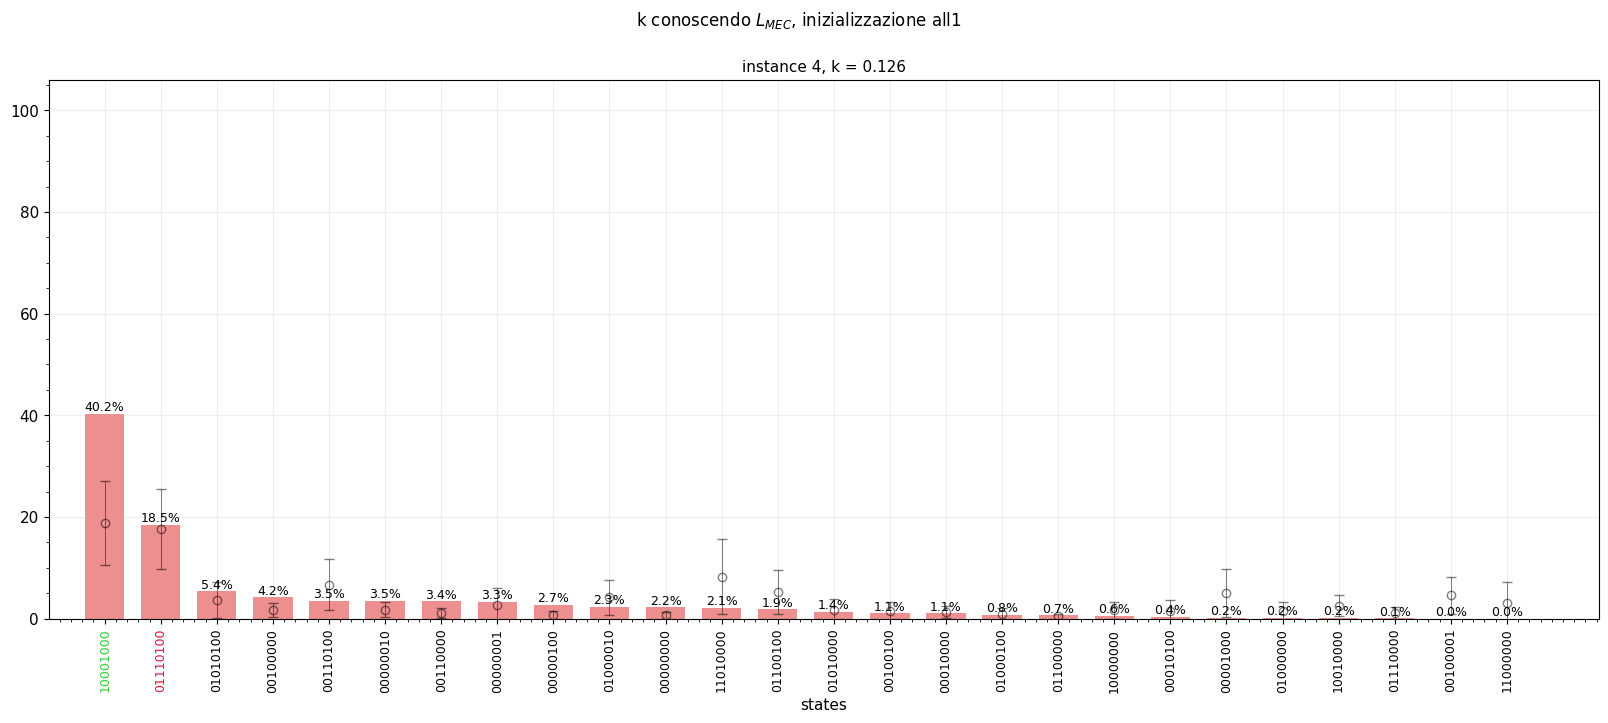

In [9]:
# headers = ["27_09/27-09@17h40m_dim6_mail3_all0_random_p3_10ra_k0.5_BOUNDS[0,2pi]x[-44,44]_pars0[0,2pi]x[-44,44]",
#           "27_09/27-09@17h45m_dim6_mail3_all0_random_p3_10ra_k0.25_BOUNDS[0,2pi]x[-110,110]_pars0[0,2pi]x[-110,110]",
#           "27_09/27-09@17h49m_dim6_mail3_all0_random_p3_10ra_k0.167_BOUNDS[0,2pi]x[-220,220]_pars0[0,2pi]x[-220,220]"]
# header = "27-09@11h09m_dim6_mail3_all1_random_p3_10ra_k0.5_BkUNDS[0,2pi]x[-44,44]_pars0[0,2pi]x[-44,44]"
# DATA_FILENAME_list = []
# FILENAME_list = []
# for header in headers:
#     DATA_FILENAME = header + '_data.txt'
#     FILENAME = header + ".csv"
#     FILENAME_list.append(FILENAME)
#     DATA_FILENAME_list.append(DATA_FILENAME)

### PRENDO I FILE CHE HANNO UNA CERTA STRINGA
import os
path = './'
# path = "./da_29_settembre/"
FILENAME_list = []
DATA_FILENAME_list = []
for i in os.listdir(path):
    if os.path.isfile(os.path.join(path,i)) and "dim8" in i:
        if '_data' in i:
            DATA_FILENAME_list.append(path+i)
        else:
            FILENAME_list.append(path+i)

## RIORDINO IN BASE AL NUMERO DELL'ISTANZA
find_number_of_instance = lambda x: int((x.split('mail')[1]).split('_all')[0])
FILENAME_list = sorted(FILENAME_list, key=find_number_of_instance)
DATA_FILENAME_list = sorted(DATA_FILENAME_list, key=find_number_of_instance)

for f,d in zip(FILENAME_list, DATA_FILENAME_list):
    print(f"{f}\n{d}\n\n")

###########################################################
###########################################################
fig = plt.figure(figsize=(20,7))
# fig.suptitle(r"$k = \frac{1}{\min |S|}$")
# fig.suptitle(r"$ k_{true} = $ max $k = $ max $\frac{1}{n}$ $\frac{L_{MEC} - |B|}{|U| - t_{max}}$")
fig.suptitle("k conoscendo $L_{MEC}$, inizializzazione all1")

N=11
plt.gca().set_title(FILENAME_list[0], fontsize=N)

num_of_subplot = 1
for FILENAME, DATA_FILENAME in zip(FILENAME_list, DATA_FILENAME_list):
    
    ##### EXTRAPOLATE INFORMATION FROM THE FILENAME
    n, instance, init_name, p, random_attempts, k = define_parameters_from_filename(DATA_FILENAME)
    print(n, instance, init_name, p, random_attempts, k)
    
    ##### WITH THIS INFORMATION, GET THE INSTANCE SETS
    U, subsets_dict = define_instance(n, instance, verbose=False)
    
    ##### FIND FEASIBLE STATES, ENERGIES, EXACT COVERS
    states, energies, states_feasible, energies_feasible, EXACT_COVERS = find_spectrum(U, subsets_dict, n, k)
    # print("\nEXACT_COVERS: ", EXACT_COVERS)
    
    ###########################################################
    ###########################################################
    
    ##### UPLOAD THE DATAFRAME FROM FILE
    df = pd.read_csv(FILENAME, dtype = str).set_index('states')
    df = df.astype(float).fillna(0.0)
    
    
    ##### COMPUTE PERCENTAGES AND ADD AVERAGE COLUMN
    total = df.sum()
    percentage = (df/ total) * 100
    
    percentage['average'] = percentage.mean(numeric_only=True, axis=1)
    percentage['std'] = percentage[percentage.columns[:-1]].std(numeric_only=True, axis=1)
    
    ##### FIND THE BEST HISTOGRAM INDEX (i_best) BASED ON THE MINIMUM ENERGY FOUND
    with open(DATA_FILENAME, 'r') as DATA_FILE:
        for line in DATA_FILE:
            if 'Attempt that reached the best result with' in line:                
                string = line.split('#')[1]
                i_best = string.split(' ')[0]
                # print("string", string)
                # print("i_best is", i_best)
                
    ##### THE COLUMN CORRESPONDING TO THE BEST RESULT
    column_best = f'counts_p{p}_{i_best}of{random_attempts}'
    
    
    ##### KEEP THE BEST AND THE AVERAGE RESULT
    percentage = percentage[[column_best, "average", "std"]]
    percentage = percentage.sort_values(column_best, ascending=False)
    
    
    ##### FIGURE
    
    # plt.figure(figsize=(12,5))
    plt.subplot(1,1,num_of_subplot)
    ax = sns.barplot(x="states", y=column_best, data=percentage, width=0.7, color='red', alpha=0.5) #label=f"Lowest energy among {random_attempts} random attempts"
    
    # Make labels with percentages.
    labels = percentage[column_best].round(1).astype('str') + '%'
    for container in ax.containers:
            ax.bar_label(container, labels=labels, fontsize=N-2)
            
    # # Display errors, but just for the "average" bars.
    x_coords = [p.get_x() + 0.5 * p.get_width() for p in ax.patches] 
    y_coords = percentage["average"]
    ax.errorbar(x=x_coords, y=y_coords, yerr=percentage["std"], linestyle="",
                markerfacecolor='none', linewidth=1,
                marker='o', color='k', ecolor='k', elinewidth=0.7, capsize=3.5, 
                barsabove=True, alpha=0.5) # label=f"Average on {random_attempts} random attempts"
    
    # Highlight exact covers' ticks with red.
    df_for_ticks = percentage.copy()
    df_for_ticks["states"] = df_for_ticks.index
    highlight_correct_ticks(ax, EXACT_COVERS)
    
    # Plot refinements.
    plt.xlabel("states", fontsize=N)
    plt.ylabel("", fontsize=N)
    plt.xticks(fontsize=N-2, rotation="vertical")
    plt.yticks(fontsize=N)
    plt.xlim(xmin=-1)
    plt.ylim(ymin=0, ymax=106)
    plt.minorticks_on()
    plt.grid(alpha=0.2)
    # plt.legend(fontsize=N)
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)
    ax.set_title(f"instance {instance}, k = {k}", fontsize=N)

    num_of_subplot += 1
    
plt.show()

## Barplot con diverse k

In [117]:
headers = ["dim6_mail5_all1_random_p3_10ra_k0.167_BOUNDS[0,2pi]x[None,None]_pars0[0,2pi]x[-1000,1000]",
           "dim6_mail5_all1_random_p3_10ra_k0.334_BOUNDS[0,2pi]x[None,None]_pars0[0,2pi]x[-1000,1000]",
          "dim6_mail5_all1_random_p3_10ra_k0.5_BOUNDS[0,2pi]x[None,None]_pars0[0,2pi]x[-1000,1000]"]
# header = "27-09@11h09m_dim6_mail3_all1_random_p3_10ra_k0.5_BOUNDS[0,2pi]x[-44,44]_pars0[0,2pi]x[-44,44]"

6 5 all1 3 10 0.167
20 

6 5 all1 3 10 0.334
20 

6 5 all1 3 10 0.5
20 



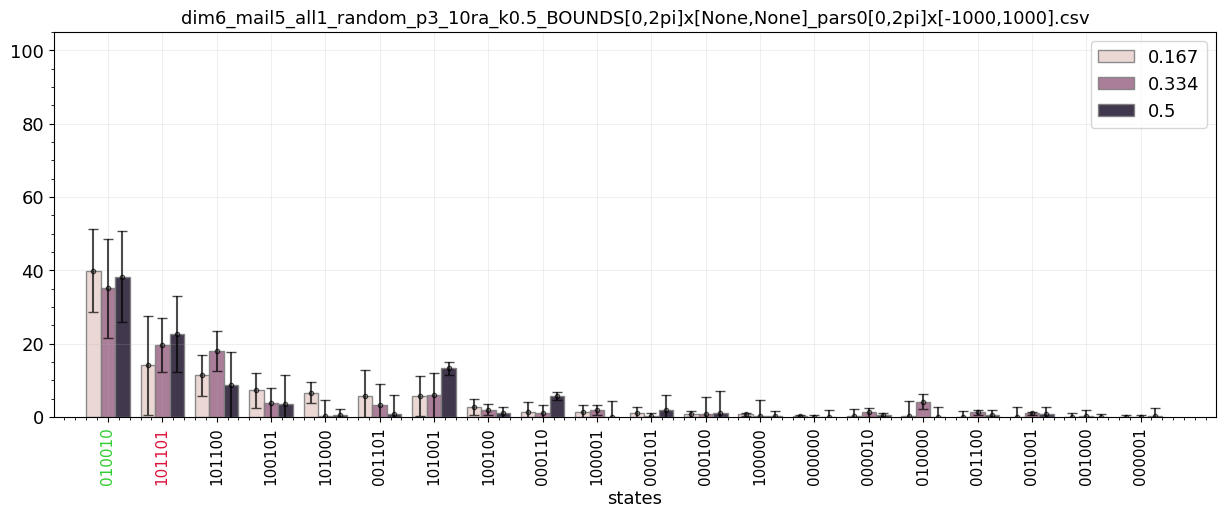

In [195]:
DATA_FILENAME_list = []
FILENAME_list = []
for header in headers:
    DATA_FILENAME = header + '_data.txt'
    FILENAME = header + ".csv"
    FILENAME_list.append(FILENAME)
    DATA_FILENAME_list.append(DATA_FILENAME)

###########################################################
###########################################################

df_barplot = []
for FILENAME, DATA_FILENAME in zip(FILENAME_list, DATA_FILENAME_list):
    
    ##### EXTRAPOLATE INFORMATION FROM THE FILENAME
    n, instance, init_name, p, random_attempts, k = define_parameters_from_filename(DATA_FILENAME)
    print(n, instance, init_name, p, random_attempts, k)
    
    ##### WITH THIS INFORMATION, GET THE INSTANCE SETS
    U, subsets_dict = define_instance(n, instance, verbose=False)
    
    ##### FIND FEASIBLE STATES, ENERGIES, EXACT COVERS
    states, energies, states_feasible, energies_feasible, EXACT_COVERS = find_spectrum(U, subsets_dict, n, k)
    # print("\nEXACT_COVERS: ", EXACT_COVERS)
    
    ###########################################################
    ###########################################################
    
    ##### UPLOAD THE DATAFRAME FROM FILE
    df = pd.read_csv(FILENAME, dtype = str).set_index('states')
    df = df.astype(float).fillna(0.0)
    
    
    ##### COMPUTE PERCENTAGES AND ADD AVERAGE COLUMN
    total = df.sum()
    percentage = (df/ total) * 100
    
    percentage['average'] = percentage.mean(numeric_only=True, axis=1)
    percentage['std'] = percentage[percentage.columns[:-1]].std(numeric_only=True, axis=1)
    
    ##### FIND THE BEST HISTOGRAM INDEX (i_best) BASED ON THE MINIMUM ENERGY FOUND
    with open(DATA_FILENAME, 'r') as DATA_FILE:
        for line in DATA_FILE:
            if 'Attempt that reached the best result with' in line:                
                string = line.split('#')[1]
                i_best = string.split(' ')[0]
                # print("string", string)
                # print("i_best is", i_best)
                
    ##### THE COLUMN CORRESPONDING TO THE BEST RESULT
    column_best = f'counts_p{p}_{i_best}of{random_attempts}'
    
    
    ##### KEEP THE BEST AND THE AVERAGE RESULT
    percentage = percentage[[column_best, "average", "std"]]
    percentage = percentage.rename(columns={column_best: "y"})
    percentage["k"] = k
    percentage = percentage.sort_values("y", ascending=False)
    print(len(percentage), "\n")
    df_barplot.append(percentage)
    
all_df = pd.concat(df_barplot)


##### FIGURE
N = 13
plt.figure(figsize=(15,5))
clrs = ["#F72585", "#7209B7", "#3A0CA3", "#4361EE", "#4CC9F0"][:len(FILENAME_list)]
# oppure palette =  sns.color_palette(clrs)
ax = sns.barplot(x="states", y="y", data=all_df, hue="k", width=0.8, alpha=0.9, palette=sns.cubehelix_palette(as_cmap=True)
)

# Fai il contorno
from matplotlib.patches import Rectangle
children = ax.get_children() # grab everything that is on the axis
for child in children:
    if isinstance(child, Rectangle): # filter for rectangles
        # clr = child.get_facecolor() # match edgecolors to facecolors
        clr = 'grey'
        child.set_edgecolor(clr)


percentage_text = 'off'
if percentage_text == 'on':
    # # Make labels with percentages.
    for i,container in enumerate(ax.containers):
        ### attenzione: sono al contrario! Ovvero
        ### df_barplot[0] corrisponde all'ultimo ax.container
        num = len(df_barplot) - 1
        labels = df_barplot[num-i%3]["y"].round(1).astype('str') + '%'
        ax.bar_label(container, labels=labels, fontsize=N-2)


# Display errors.
i = 0
f = 0
for j,df in enumerate(df_barplot):
    f += len(df)    
    x_coords = [p.get_x() + 0.5 * p.get_width() for p in ax.patches[i:f]]
    ### x_coords ha prima h'array delle coordinate delle barre che compaiono con il colore 1,
    ### poi quello con le coordinate del colore 2, etc.
    y_coords = [p.get_height() for p in ax.patches[i:f]]
    ax.errorbar(x=x_coords, y=y_coords, yerr=df["std"], fmt=".", markerfacecolor='None', c="k", capsize=3.5, alpha=0.7)
    i += len(df)



        
# Highlight exact covers' ticks with red.
highlight_correct_ticks(ax, EXACT_COVERS)



# Plot refinements.
plt.title(FILENAME, fontsize=N)
plt.xlabel("states", fontsize=N)
plt.ylabel("", fontsize=N)
plt.xticks(fontsize=N-2, rotation="vertical")
plt.yticks(fontsize=N)
plt.xlim(xmin=-1)
plt.ylim(ymin=0, ymax=105)
plt.minorticks_on()
plt.grid(alpha=0.2)
plt.legend(fontsize=N)

plt.show()
